In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis


import sys
sys.path.append('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/')

In [2]:
from functions import (interpolate_pulses, create_position, calculate_gaussian_center_sigma, 
                       get_mean_pulse_from_set, move_to_reference, plot_gaussian, get_gaussian_params)

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

test_data = np.load(os.path.join(dir, 'Na22_test_val.npz'))['data']

In [4]:
# -------------------------------------------------------------------------
#----------------------- IMPORTANT DEFINITIONS ----------------------------
# -------------------------------------------------------------------------
nbins = 91              # Num bins for all histograms                   
t_shift = 8             # Time steps to move for the new positions
EXTRASAMPLING = 8
start_idx =30
stop_idx = 94
start = start_idx*EXTRASAMPLING 
stop = stop_idx*EXTRASAMPLING 

In [5]:
# -------------------------------------------------------------------------
#----------------------- INTERPOLATE PULSES -------------------------------
# -------------------------------------------------------------------------
new_test, new_time_step =  interpolate_pulses(test_data, EXTRASAMPLING = EXTRASAMPLING, time_step = 0.2)

# Align pulses 
align_steps = 20

new_test[:,:,1] = np.roll(new_test[:,:,1], align_steps)
new_test[:,:align_steps,1] = np.random.normal(scale = 1e-6, size = align_steps)

print('New number of time points: %.d' % (new_test.shape[1]))
print('New time step: %.4f' % (new_time_step))

New number of time points: 4800
New time step: 0.0250


In [6]:
# Move all pulses to a reference to eliminate time dependencies
mean_pulse_dec0 = get_mean_pulse_from_set(new_test, channel = 0)
mean_pulse_dec1 = get_mean_pulse_from_set(new_test, channel = 1)

delays_dec0, moved_pulses_dec0 = move_to_reference(mean_pulse_dec0, new_test, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
delays_dec1, moved_pulses_dec1 = move_to_reference(mean_pulse_dec1, new_test, start = start, stop = stop, max_delay = int(stop-start), channel = 1)

test_data = np.stack((moved_pulses_dec0, moved_pulses_dec1), axis = -1)

# Create the other positions
TEST_00 = test_data 
TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)
TEST = np.concatenate((TEST_02, TEST_00, TEST_20, TEST_04, TEST_40), axis = 0)

KeyboardInterrupt: 

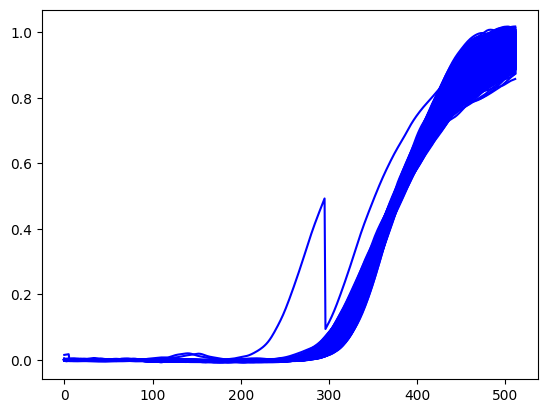

In [7]:
for i in range(TEST_00.shape[0]):
    plt.plot(TEST_00[i,:,0], 'b-')

In [8]:
# Load model predictions
pred_dec0 = np.load('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/predictions/test_dec0_Na22.npz', allow_pickle = True)['data']
pred_dec1 = np.load('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/predictions/test_dec1_Na22.npz', allow_pickle = True)['data']


# Calculate TOF and extract the different positions
TOF = pred_dec0[-1,:] - pred_dec1[-1,:]

TOF_V02 = TOF[:test_data.shape[0]] 
TOF_V00 = TOF[test_data.shape[0] : 2*test_data.shape[0]] 
TOF_V20 = TOF[2*test_data.shape[0] :3*test_data.shape[0]] 
TOF_V04 = TOF[3*test_data.shape[0] :4*test_data.shape[0]] 
TOF_V40 = TOF[4*test_data.shape[0]:] 


# Calculate errors
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOF_V00[None, :], np.zeros((TOF_V00[None, :].shape[0])), nbins = nbins) 

error_V02 = (TOF_V02 - centroid_V00 + new_time_step*t_shift)
error_V00 = (TOF_V00 - centroid_V00)
error_V20 = (TOF_V20 - centroid_V00 - new_time_step*t_shift)
error_V04 = (TOF_V04 - centroid_V00 + 2*new_time_step*t_shift)
error_V40 = (TOF_V40 - centroid_V00 - 2*new_time_step*t_shift)


Error = np.concatenate((error_V02, error_V20, error_V00, error_V04, error_V40))

In [9]:
# Get time independent parameters
mean = np.mean(TEST, axis = 1)
variance= np.var(TEST, axis = 1)
skewness = skew(TEST, axis = 1)
kurtosis = kurtosis(TEST, axis = 1)


# Concatenate the features
features = np.stack((mean[:,0], variance[:,0], skewness[:,0], kurtosis[:,0], 
                     mean[:,1], variance[:,1], skewness[:,1], kurtosis[:,1]), axis = 1)

In [10]:
# Save to a DataFrame 
features_df = pd.DataFrame(features, columns = ['Mean_dec0', 'Variance_dec0', 'Skewness_dec0', 'Kurtosis_dec0',
                                                'Mean_dec1', 'Variance_dec1', 'Skewness_dec1', 'Kurtosis_dec1'])

In [11]:
from pycaret.regression import *
s = setup(features_df, target = Error,  session_id = 123, normalize = True, normalize_method = 'zscore')

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(15375, 9)"
4,Transformed data shape,"(15375, 9)"
5,Transformed train set shape,"(10762, 9)"
6,Transformed test set shape,"(4613, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [12]:
model = compare_models('')
print(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0673,0.0097,0.0984,0.2621,0.0000,1.9462,0.2880
et,Extra Trees Regressor,0.0710,0.0110,0.1047,0.1647,0.0000,2.0541,0.0690
gbr,Gradient Boosting Regressor,0.0766,0.0121,0.1098,0.0810,0.0000,1.5488,0.1900
lr,Linear Regression,0.0763,0.0128,0.1128,0.0314,0.0000,1.7399,0.3340
ridge,Ridge Regression,0.0763,0.0128,0.1128,0.0314,0.0000,1.7278,0.0750
br,Bayesian Ridge,0.0763,0.0128,0.1128,0.0312,0.0000,1.7249,0.0030
huber,Huber Regressor,0.0759,0.0128,0.1130,0.0287,0.0000,1.9003,0.0080
omp,Orthogonal Matching Pursuit,0.0790,0.0131,0.1144,0.0037,0.0000,1.2276,0.0030
llar,Lasso Least Angle Regression,0.0793,0.0132,0.1147,-0.0009,0.0000,1.0067,0.0030
lasso,Lasso Regression,0.0793,0.0132,0.1147,-0.0009,0.0000,1.0067,0.0730


RandomForestRegressor(n_jobs=-1, random_state=123)


In [13]:
# Get more detailed model evaluations
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

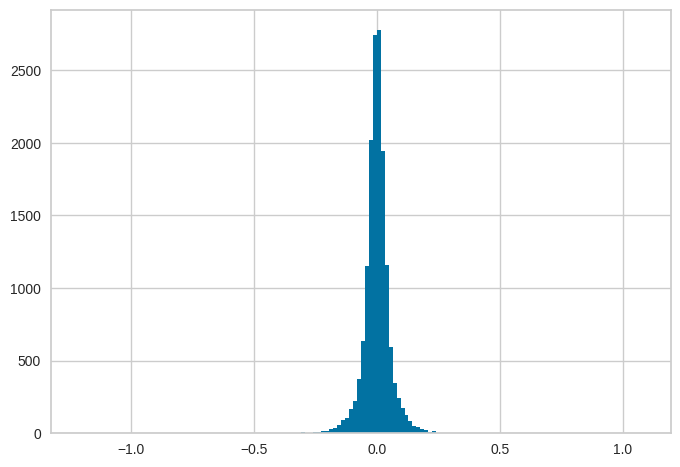

In [14]:
predictions_ML = predict_model(model, data = features_df)

Error_pred = predictions_ML['prediction_label'].to_numpy() - Error
plt.hist(Error_pred, bins = nbins + 51);

# **CORRECT PREDICTIONS**

In [15]:
TOF_corr = TOF - predictions_ML['prediction_label'].to_numpy() 

TOF_V02_corr = TOF_corr[:test_data.shape[0]] 
TOF_V00_corr = TOF_corr[test_data.shape[0] : 2*test_data.shape[0]] 
TOF_V20_corr = TOF_corr[2*test_data.shape[0] :3*test_data.shape[0]] 
TOF_V04_corr = TOF_corr[3*test_data.shape[0] :4*test_data.shape[0]] 
TOF_V40_corr = TOF_corr[4*test_data.shape[0]:] 

V40: CENTROID(ns) = 0.4005 +/- 0.00033  FWHM(ns) = 0.0720 +/- 0.00034
V20: CENTROID(ns) = 0.1996 +/- 0.00033  FWHM(ns) = 0.0645 +/- 0.00034
V00: CENTROID(ns) = -0.0002 +/- 0.00039  FWHM(ns) = 0.0676 +/- 0.00039
V02: CENTROID(ns) = -0.2006 +/- 0.00051  FWHM(ns) = 0.0842 +/- 0.00053
V04: CENTROID(ns) = -0.4002 +/- 0.00041  FWHM(ns) = 0.0893 +/- 0.00042



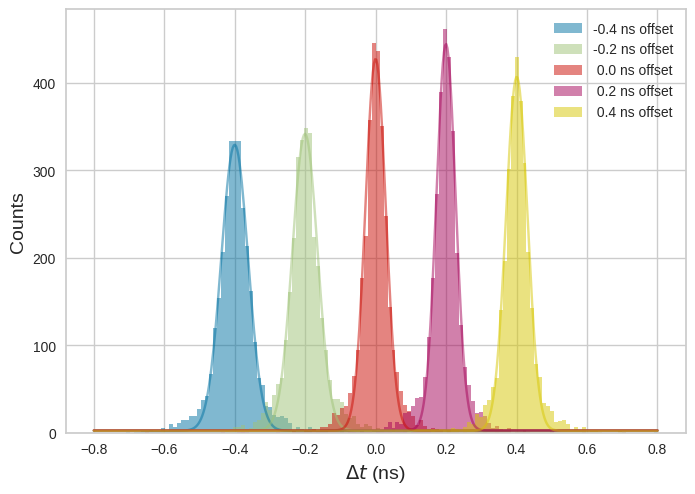

In [16]:
centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOF_V00_corr[None, :], np.zeros((TOF_V00_corr[None, :].shape[0])), nbins = nbins + 51) 


# Histogram and gaussian fit 
plot_gaussian(TOF_V04_corr, centroid_V00, range = 0.8, label = '-0.4 ns offset', nbins = nbins + 51)
plot_gaussian(TOF_V02_corr, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins + 51)
plot_gaussian(TOF_V00_corr, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins + 51)
plot_gaussian(TOF_V20_corr, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins + 51)
plot_gaussian(TOF_V40_corr, centroid_V00, range = 0.8, label = ' 0.4 ns offset', nbins = nbins + 51)


params_V04, errors_V04 = get_gaussian_params(TOF_V04_corr, centroid_V00, range = 0.8, nbins = nbins + 51)
params_V02, errors_V02 = get_gaussian_params(TOF_V02_corr, centroid_V00, range = 0.8, nbins = nbins + 51)
params_V00, errors_V00 = get_gaussian_params(TOF_V00_corr, centroid_V00, range = 0.8, nbins = nbins + 51)
params_V20, errors_V20 = get_gaussian_params(TOF_V20_corr, centroid_V00, range = 0.8, nbins = nbins + 51)
params_V40, errors_V40 = get_gaussian_params(TOF_V40_corr, centroid_V00, range = 0.8, nbins = nbins + 51)


print("V40: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V40[2], errors_V40[2], params_V40[3], errors_V40[3]))
print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))
print("V04: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V04[2], errors_V04[2], params_V04[3], errors_V04[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.show()


duplicar etiquetas?? data augmentation??
revisar y vs y_hat hacerlo yo